# Imports

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict, LeaveOneOut, train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Algoritmo

In [6]:
def RFR(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "R²": r2,
            "Correlation coefficient": correlation_coefficient,
            "RMSE": rmse,
            "MAE": mae,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset
        }

    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        RandomForestRegressor(
            n_estimators=80,
            max_features='log2', # Usar raiz quadrada do número de características
            max_depth=20,    # Profundidade das árvores
            # min_samples_split=5,  # Número mínimo de amostras necessárias para dividir um nó
            # min_samples_leaf=1,   # Número mínimo de amostras necessárias em um nó folha
            bootstrap=True,    # Usar amostragem bootstrap
            oob_score=False,   # Não usar amostragem fora da bolsa
            random_state=1     # Semente aleatória
        )
    )

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results_df = pd.DataFrame({
        "Attribute": [attribute, attribute, attribute],
        "Y": ["Training", "Cross-Validation", "Validation"],
        "R²": [training_metrics["R²"], cv_metrics["R²"], validation_metrics["R²"]],
        "Correlation coefficient": [training_metrics["Correlation coefficient"], cv_metrics["Correlation coefficient"], validation_metrics["Correlation coefficient"]],
        "RMSE": [training_metrics["RMSE"], cv_metrics["RMSE"], validation_metrics["RMSE"]],
        "MAE": [training_metrics["MAE"], cv_metrics["MAE"], validation_metrics["MAE"]],
        "Relative absolute error": [training_metrics["Relative absolute error"], cv_metrics["Relative absolute error"], validation_metrics["Relative absolute error"]],
        "Root relative squared error": [training_metrics["Root relative squared error"], cv_metrics["Root relative squared error"], validation_metrics["Root relative squared error"]],
        "Slope": [training_metrics["Slope"], cv_metrics["Slope"], validation_metrics["Slope"]],
        "Offset": [training_metrics["Offset"], cv_metrics["Offset"], validation_metrics["Offset"]]
    })
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}:Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df


# Ajusta saída

In [7]:
infos_msc = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_snv = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])
infos_sg = pd.DataFrame(columns=['Attribute', 'Y', 'R²', 'Correlation coefficient', 'RMSE', 'MAE', 'Relative absolute error', 'Root relative squared error', 'Slope', 'Offset'])


def add_plot_infos(plot_infos_pre, plot_infos_df, attribute):
    # Cria uma cópia do DataFrame para evitar alterações no original
    plot_infos_df = plot_infos_df.copy()
    
    # Adiciona a coluna 'Attribute' ao DataFrame plot_infos_df
    plot_infos_df['Attribute'] = attribute
    
    # Adiciona a nova linha ao DataFrame existente
    plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)
    
    return plot_infos_pre


# MSC - RFR

=== Training Metrics ===
R²: 0.9529
Correlation coefficient: 0.9797
RMSE: 0.5766
MAE: 0.4600
Relative absolute error: 20.8355
Root relative squared error: 21.7053
Slope: 1.0923
Offset: -1.3078
=== Cross-Validation Metrics ===
R²: 0.6693
Correlation coefficient: 0.8181
RMSE: 1.5276
MAE: 1.2250
Relative absolute error: 55.4814
Root relative squared error: 57.5053
Slope: 1.0021
Offset: -0.0359
=== Validation Metrics ===
R²: 0.6593
Correlation coefficient: 0.8152
RMSE: 1.2282
MAE: 1.0227
Relative absolute error: 59.3408
Root relative squared error: 58.3669
Slope: 0.9187
Offset: 1.1261


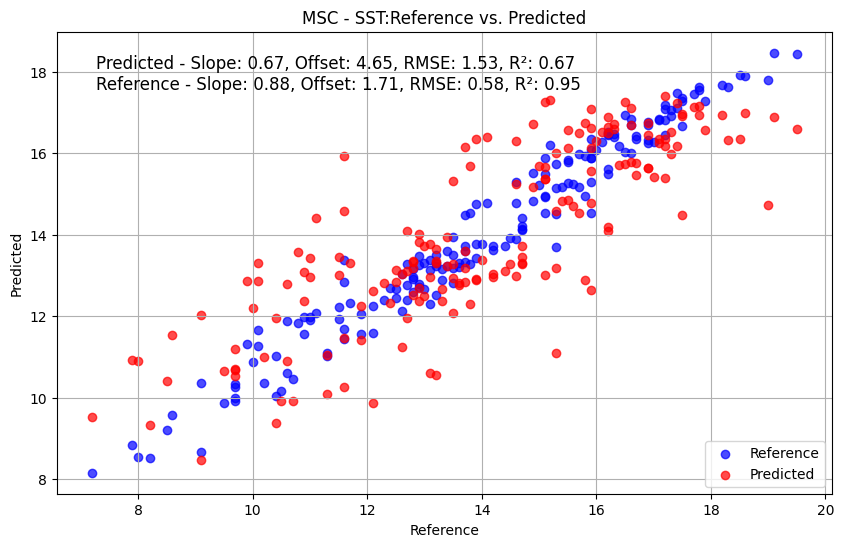

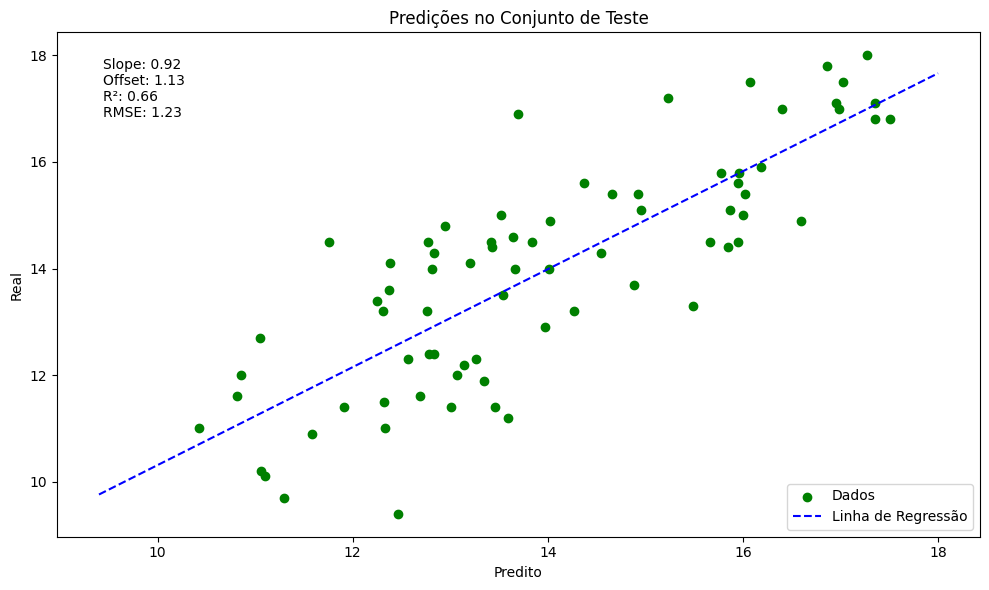

C:\Users\Luyza\AppData\Local\Temp\ipykernel_20116\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [8]:
results_msc_sst = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['SST'].values, df_msc_val.iloc[:, 6:], df_msc_val['SST'].values, 'MSC', 'SST')
infos_msc = add_plot_infos(infos_msc, results_msc_sst, 'SST')

=== Training Metrics ===
R²: 0.9120
Correlation coefficient: 0.9671
RMSE: 0.1740
MAE: 0.0947
Relative absolute error: 20.9539
Root relative squared error: 29.6713
Slope: 1.1878
Offset: -0.2108
=== Cross-Validation Metrics ===
R²: 0.4485
Correlation coefficient: 0.6705
RMSE: 0.4355
MAE: 0.2574
Relative absolute error: 56.9632
Root relative squared error: 74.2647
Slope: 0.9660
Offset: 0.0253
=== Validation Metrics ===
R²: 0.5411
Correlation coefficient: 0.7491
RMSE: 0.2963
MAE: 0.2112
Relative absolute error: 59.4033
Root relative squared error: 67.7419
Slope: 0.8687
Offset: 0.1119


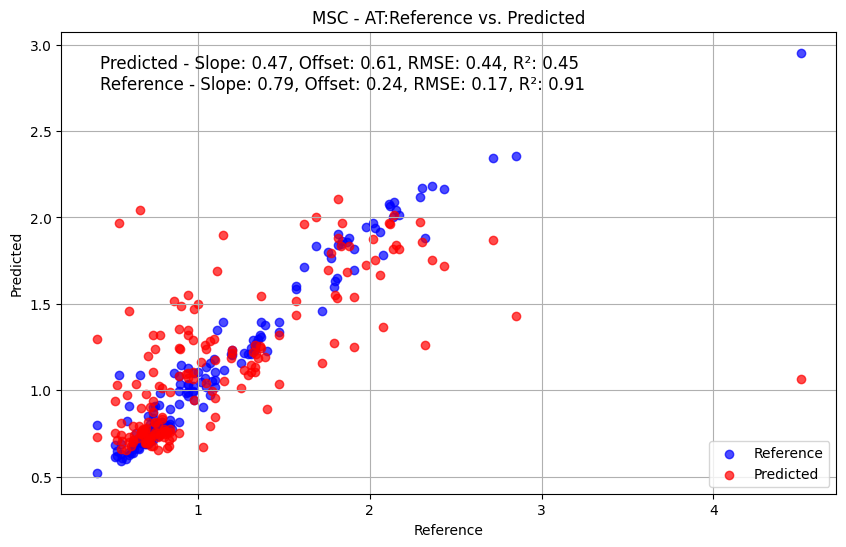

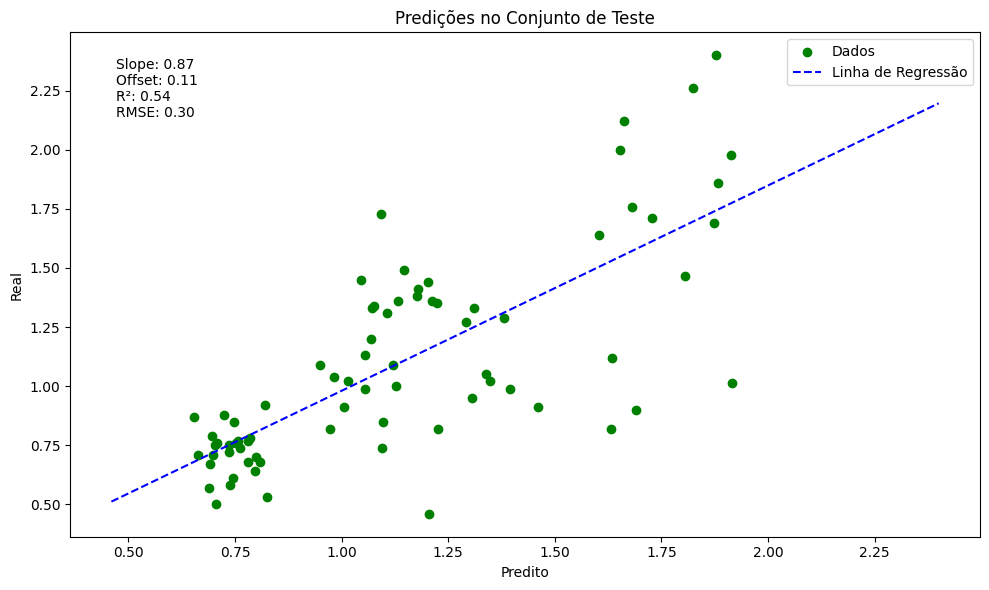

In [9]:
results_msc_at = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['AT'].values, df_msc_val.iloc[:, 6:], df_msc_val['AT'].values, 'MSC', 'AT')
infos_msc = add_plot_infos(infos_msc, results_msc_at, 'AT')

=== Training Metrics ===
R²: 0.9074
Correlation coefficient: 0.9711
RMSE: 0.0939
MAE: 0.0573
Relative absolute error: 23.8813
Root relative squared error: 30.4316
Slope: 1.2407
Offset: -0.7940
=== Cross-Validation Metrics ===
R²: 0.3222
Correlation coefficient: 0.5693
RMSE: 0.2539
MAE: 0.1538
Relative absolute error: 64.0986
Root relative squared error: 82.3310
Slope: 0.9511
Offset: 0.1510
=== Validation Metrics ===
R²: 0.2533
Correlation coefficient: 0.5682
RMSE: 0.2277
MAE: 0.1600
Relative absolute error: 67.8828
Root relative squared error: 86.4134
Slope: 0.6837
Offset: 1.0452


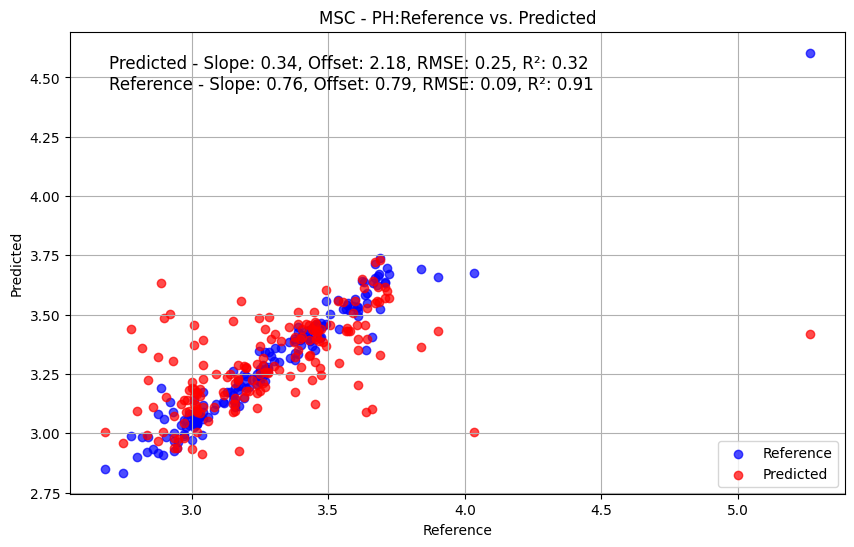

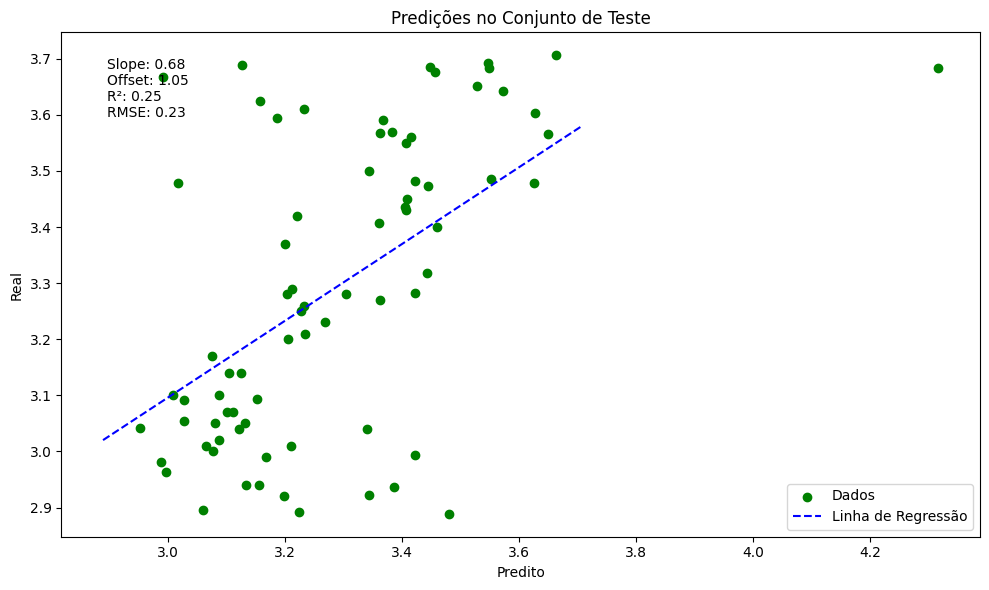

In [10]:
results_msc_ph = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['PH'].values, df_msc_val.iloc[:, 6:], df_msc_val['PH'].values, 'MSC', 'PH')
infos_msc = add_plot_infos(infos_msc, results_msc_ph, 'PH')

=== Training Metrics ===
R²: 0.9205
Correlation coefficient: 0.9694
RMSE: 28.9754
MAE: 23.5610
Relative absolute error: 28.2950
Root relative squared error: 28.1944
Slope: 1.1664
Offset: -86.7422
=== Cross-Validation Metrics ===
R²: 0.4467
Correlation coefficient: 0.6694
RMSE: 76.4452
MAE: 62.2620
Relative absolute error: 74.7721
Root relative squared error: 74.3847
Slope: 0.9483
Offset: 27.6297
=== Validation Metrics ===
R²: 0.4766
Correlation coefficient: 0.7203
RMSE: 55.8900
MAE: 45.1524
Relative absolute error: 71.1378
Root relative squared error: 72.3444
Slope: 0.8319
Offset: 75.1236


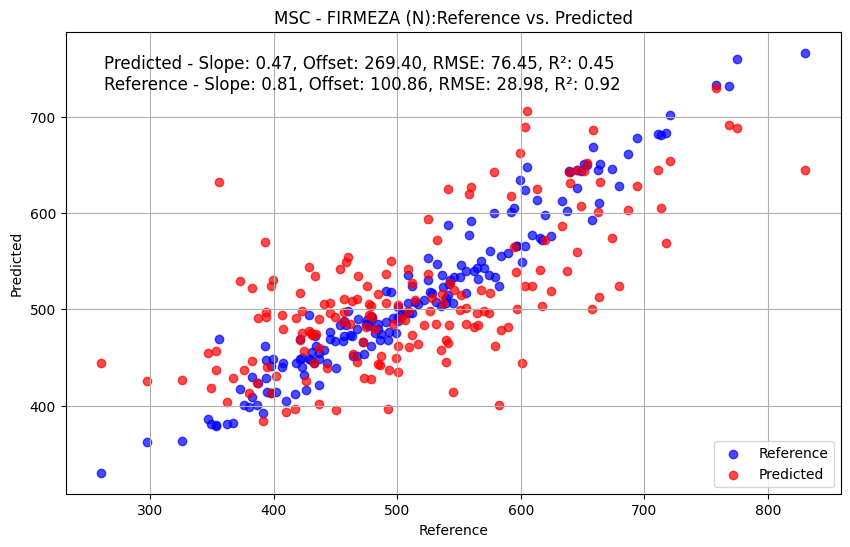

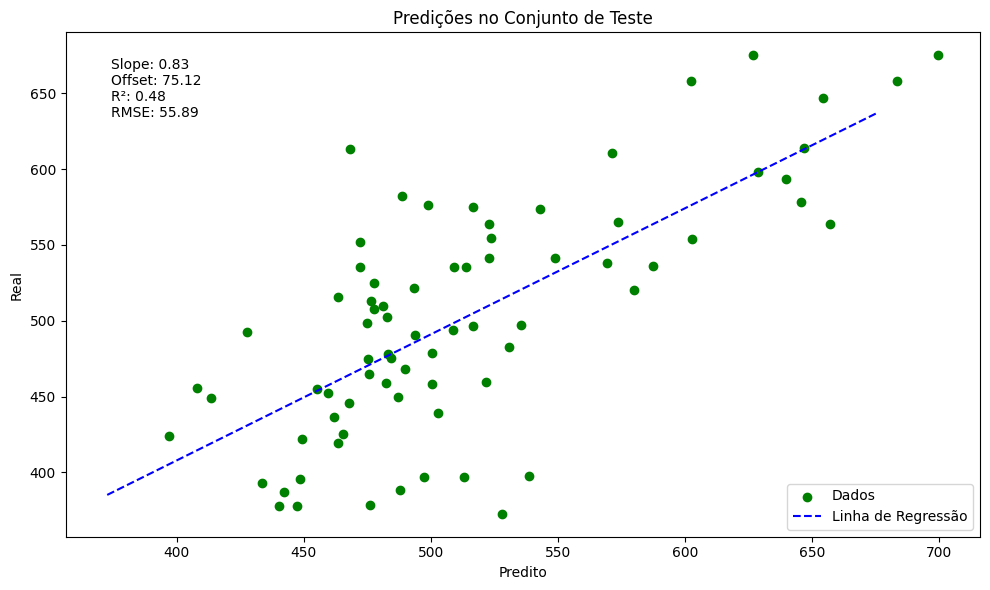

In [11]:
results_msc_firmeza = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['FIRMEZA (N)'].values, df_msc_val.iloc[:, 6:], df_msc_val['FIRMEZA (N)'].values, 'MSC', 'FIRMEZA (N)')
infos_msc = add_plot_infos(infos_msc, results_msc_firmeza, 'FIRMEZA (N)')


=== Training Metrics ===
R²: 0.9364
Correlation coefficient: 0.9743
RMSE: 0.8112
MAE: 0.4667
Relative absolute error: 18.8907
Root relative squared error: 25.2186
Slope: 1.1313
Offset: -2.0038
=== Cross-Validation Metrics ===
R²: 0.5935
Correlation coefficient: 0.7705
RMSE: 2.0509
MAE: 1.2571
Relative absolute error: 50.8802
Root relative squared error: 63.7548
Slope: 0.9922
Offset: 0.1551
=== Validation Metrics ===
R²: 0.6285
Correlation coefficient: 0.8345
RMSE: 1.3209
MAE: 0.9534
Relative absolute error: 53.7030
Root relative squared error: 60.9512
Slope: 0.7651
Offset: 3.4936


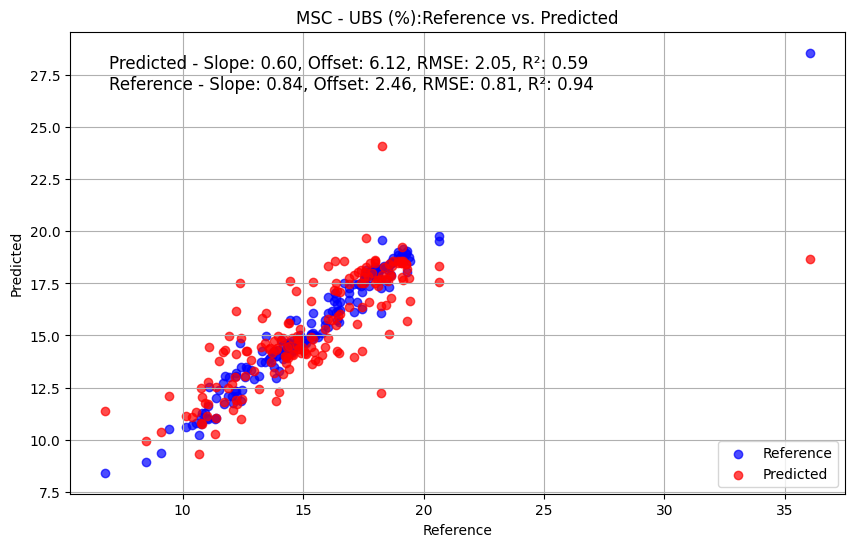

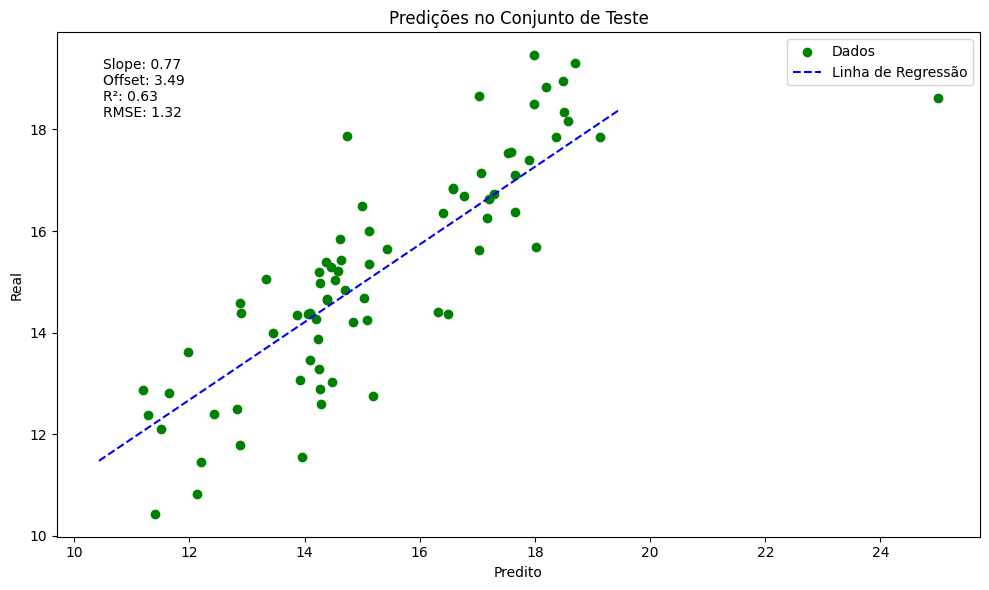

In [12]:
results_msc_ubs = RFR(df_msc_cal.iloc[:, 6:], df_msc_cal['UBS (%)'].values, df_msc_val.iloc[:, 6:], df_msc_val['UBS (%)'].values, 'MSC', 'UBS (%)')
infos_msc = add_plot_infos(infos_msc, results_msc_ubs, 'UBS (%)')

In [13]:
infos_msc.to_excel('plot_infos_RFR_msc.xlsx', index=False)
infos_msc

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.952888,0.979678,0.576579,0.460043,20.835521,21.705308,1.092270,-1.307832
1,SST,Cross-Validation,0.669314,0.818121,1.527569,1.225014,55.481376,57.505324,1.002097,-0.035874
2,SST,Validation,0.659330,0.815209,1.228235,1.022750,59.340768,58.366929,0.918681,1.126119
3,AT,Training,0.911962,0.967129,0.173999,0.094679,20.953918,29.671269,1.187775,-0.210755
4,AT,Cross-Validation,0.448475,0.670480,0.435505,0.257385,56.963181,74.264744,0.966039,0.025290
5,AT,Validation,0.541103,0.749115,0.296291,0.211232,59.403297,67.741918,0.868656,0.111889
6,PH,Training,0.907392,0.971063,0.093857,0.057289,23.881334,30.431586,1.240735,-0.793952
7,PH,Cross-Validation,0.322160,0.569295,0.253926,0.153766,64.098588,82.331020,0.951097,0.150984
8,PH,Validation,0.253272,0.568245,0.227729,0.159956,67.882787,86.413447,0.683659,1.045203
9,FIRMEZA (N),Training,0.920508,0.969416,28.975396,23.560981,28.295000,28.194408,1.166414,-86.742152


# SNV - RFR

=== Training Metrics ===
R²: 0.9549
Correlation coefficient: 0.9803
RMSE: 0.5527
MAE: 0.4443
Relative absolute error: 20.7535
Root relative squared error: 21.2343
Slope: 1.0864
Offset: -1.1955
=== Cross-Validation Metrics ===
R²: 0.6871
Correlation coefficient: 0.8290
RMSE: 1.4560
MAE: 1.1743
Relative absolute error: 54.8562
Root relative squared error: 55.9400
Slope: 0.9895
Offset: 0.1595
=== Validation Metrics ===
R²: 0.6903
Correlation coefficient: 0.8450
RMSE: 1.2502
MAE: 0.9811
Relative absolute error: 52.7839
Root relative squared error: 55.6512
Slope: 0.8621
Offset: 1.8081


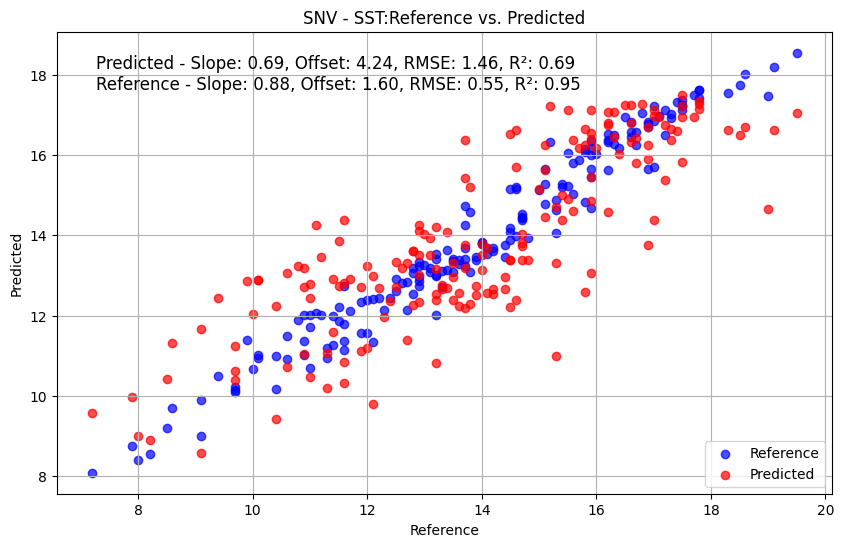

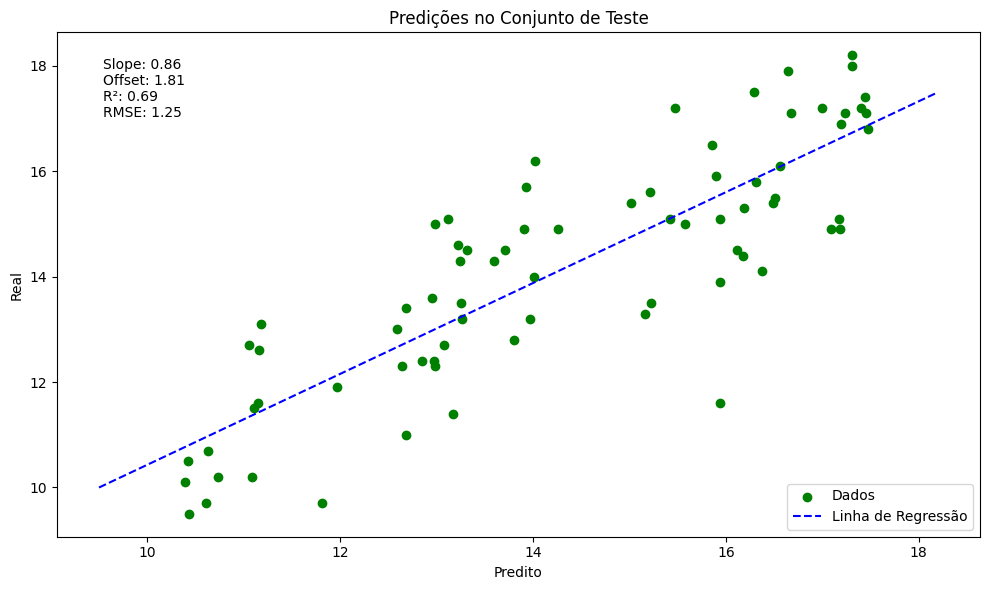

C:\Users\Luyza\AppData\Local\Temp\ipykernel_20116\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [14]:
results_snv_sst = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['SST'].values, df_snv_val.iloc[:, 6:], df_snv_val['SST'].values, 'SNV', 'SST')
infos_snv = add_plot_infos(infos_snv, results_snv_sst, 'SST')

=== Training Metrics ===
R²: 0.9186
Correlation coefficient: 0.9692
RMSE: 0.1595
MAE: 0.0941
Relative absolute error: 22.2866
Root relative squared error: 28.5295
Slope: 1.1731
Offset: -0.2072
=== Cross-Validation Metrics ===
R²: 0.3598
Correlation coefficient: 0.6097
RMSE: 0.4474
MAE: 0.2631
Relative absolute error: 62.2793
Root relative squared error: 80.0147
Slope: 0.8630
Offset: 0.1293
=== Validation Metrics ===
R²: 0.7098
Correlation coefficient: 0.8445
RMSE: 0.2767
MAE: 0.1837
Relative absolute error: 43.6850
Root relative squared error: 53.8748
Slope: 1.0732
Offset: -0.0868


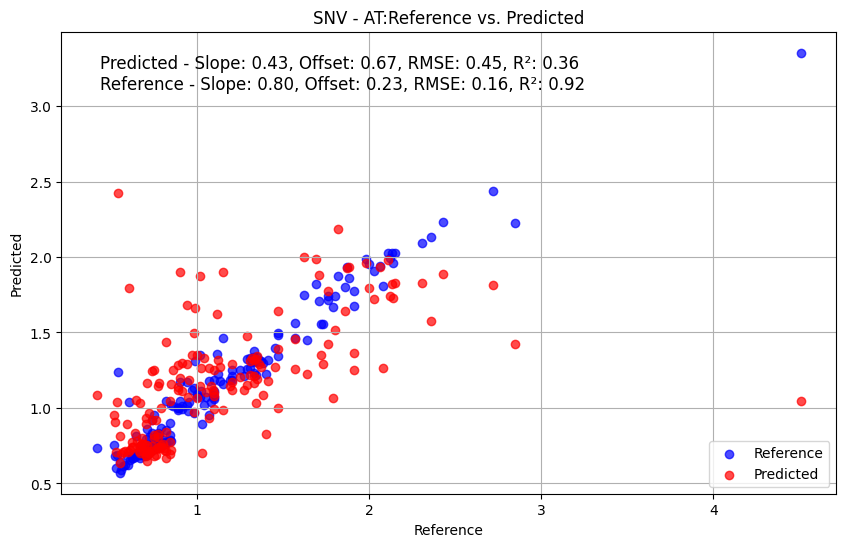

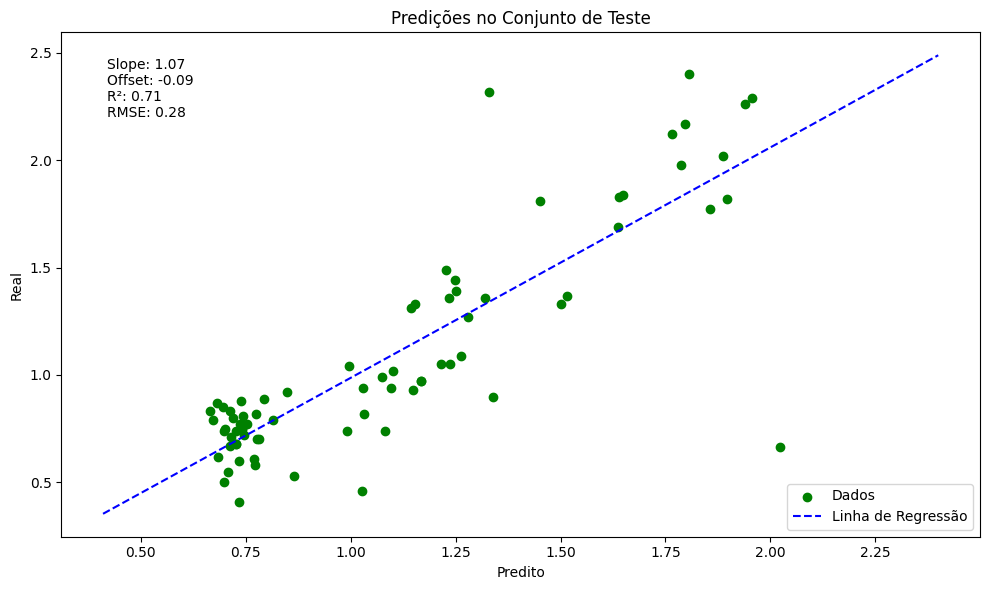

In [15]:
results_snv_at = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['AT'].values, df_snv_val.iloc[:, 6:], df_snv_val['AT'].values, 'SNV', 'AT')
infos_snv = add_plot_infos(infos_snv, results_snv_at, 'AT')

=== Training Metrics ===
R²: 0.9102
Correlation coefficient: 0.9717
RMSE: 0.0938
MAE: 0.0607
Relative absolute error: 24.4077
Root relative squared error: 29.9686
Slope: 1.2337
Offset: -0.7741
=== Cross-Validation Metrics ===
R²: 0.3542
Correlation coefficient: 0.5975
RMSE: 0.2516
MAE: 0.1577
Relative absolute error: 63.4405
Root relative squared error: 80.3601
Slope: 0.9909
Offset: 0.0136
=== Validation Metrics ===
R²: 0.5250
Correlation coefficient: 0.7271
RMSE: 0.1701
MAE: 0.1157
Relative absolute error: 54.6728
Root relative squared error: 68.9199
Slope: 0.9932
Offset: 0.0074


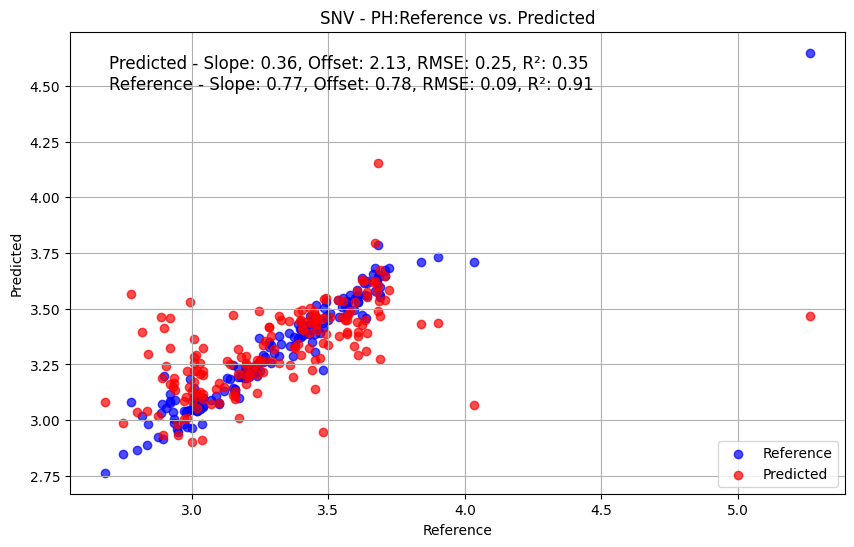

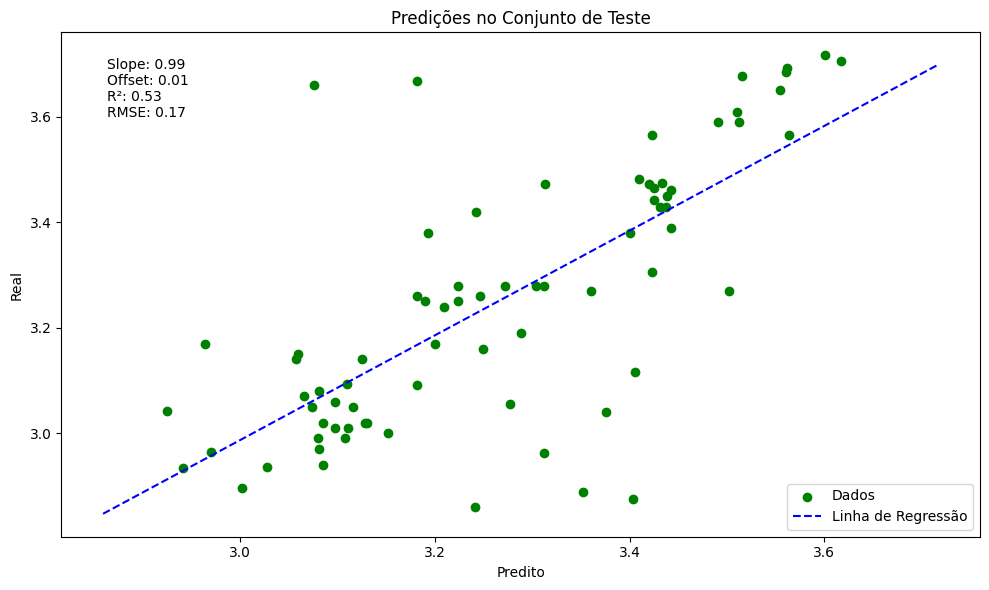

In [16]:
results_snv_ph = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['PH'].values, df_snv_val.iloc[:, 6:], df_snv_val['PH'].values, 'SNV', 'PH')
infos_snv = add_plot_infos(infos_snv, results_snv_ph, 'PH')

=== Training Metrics ===
R²: 0.9190
Correlation coefficient: 0.9707
RMSE: 28.7675
MAE: 23.0745
Relative absolute error: 28.5304
Root relative squared error: 28.4574
Slope: 1.1866
Offset: -96.5064
=== Cross-Validation Metrics ===
R²: 0.3846
Correlation coefficient: 0.6254
RMSE: 79.3047
MAE: 63.5626
Relative absolute error: 78.5918
Root relative squared error: 78.4498
Slope: 0.8891
Offset: 55.0126
=== Validation Metrics ===
R²: 0.5617
Correlation coefficient: 0.7739
RMSE: 54.1982
MAE: 47.5854
Relative absolute error: 70.9286
Root relative squared error: 66.2071
Slope: 0.9310
Offset: 20.4264


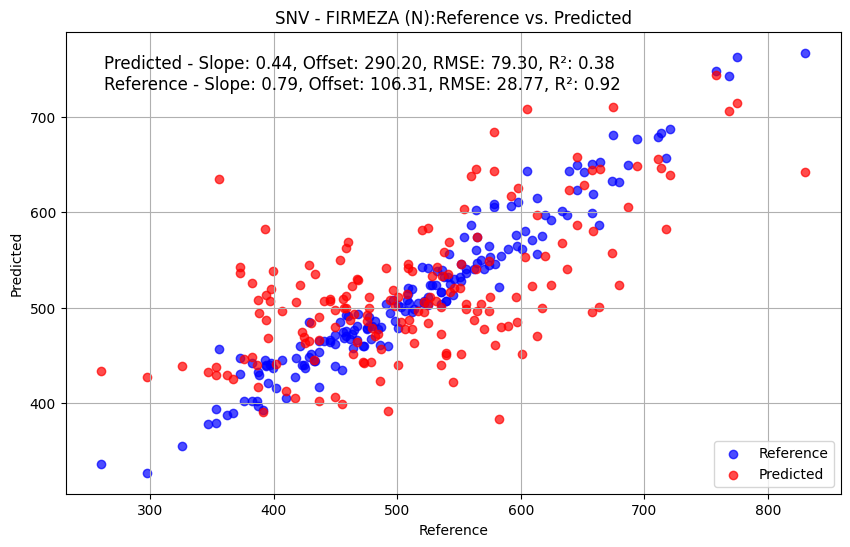

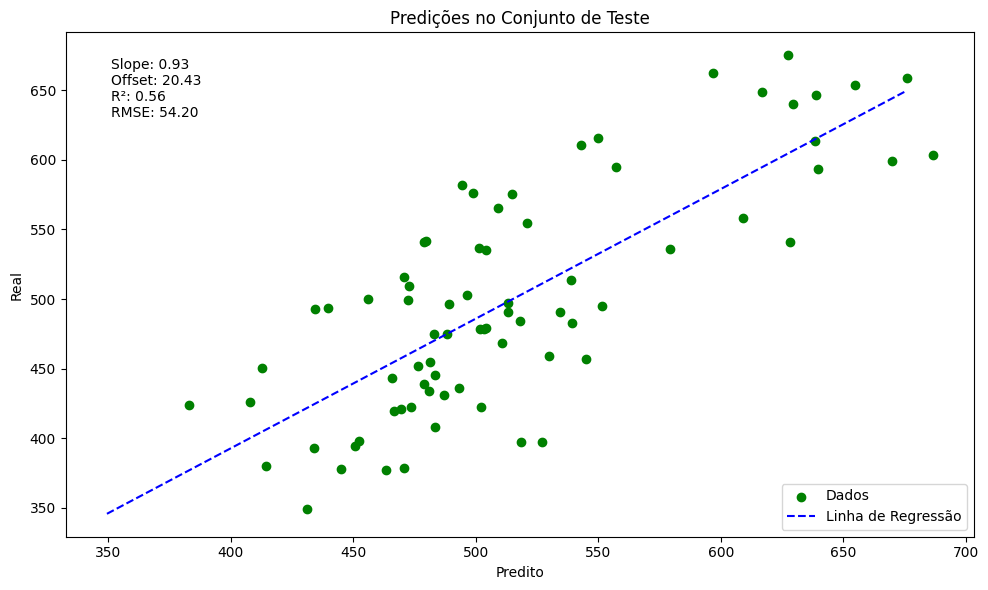

In [17]:
results_snv_firmeza = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['FIRMEZA (N)'].values, df_snv_val.iloc[:, 6:], df_snv_val['FIRMEZA (N)'].values, 'SNV', 'FIRMEZA (N)')
infos_snv = add_plot_infos(infos_snv, results_snv_firmeza, 'FIRMEZA (N)')

=== Training Metrics ===
R²: 0.9326
Correlation coefficient: 0.9708
RMSE: 0.8168
MAE: 0.4647
Relative absolute error: 19.4869
Root relative squared error: 25.9576
Slope: 1.1133
Offset: -1.7114
=== Cross-Validation Metrics ===
R²: 0.5603
Correlation coefficient: 0.7529
RMSE: 2.0865
MAE: 1.2473
Relative absolute error: 52.3059
Root relative squared error: 66.3105
Slope: 0.9026
Offset: 1.5034
=== Validation Metrics ===
R²: 0.7128
Correlation coefficient: 0.8618
RMSE: 1.2850
MAE: 0.9535
Relative absolute error: 48.2857
Root relative squared error: 53.5949
Slope: 0.8566
Offset: 2.0052


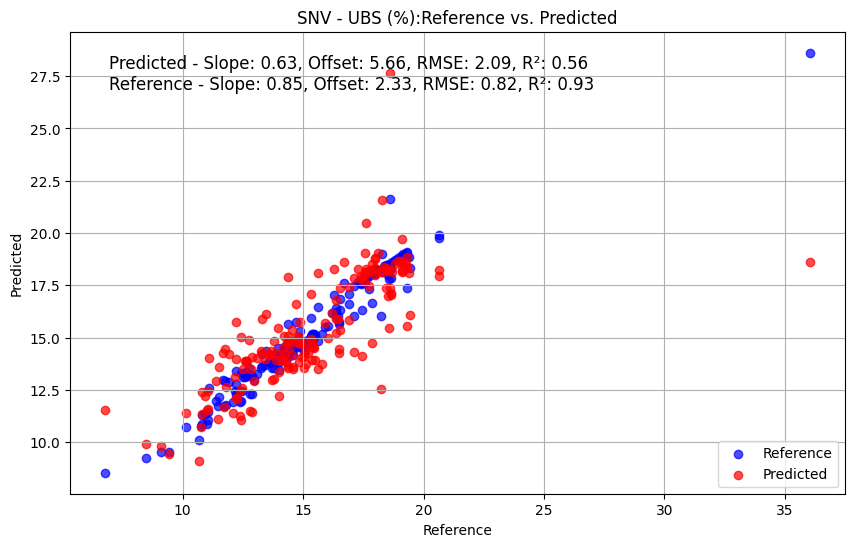

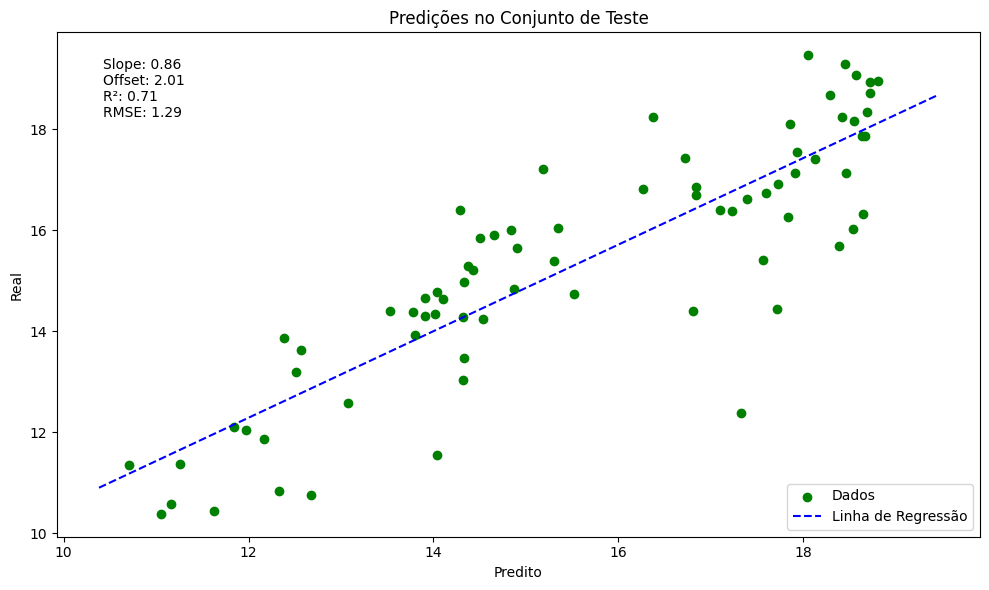

In [18]:
results_snv_ubs = RFR(df_snv_cal.iloc[:, 6:], df_snv_cal['UBS (%)'].values, df_snv_val.iloc[:, 6:], df_snv_val['UBS (%)'].values, 'SNV', 'UBS (%)')
infos_snv = add_plot_infos(infos_snv, results_snv_ubs, 'UBS (%)')

In [19]:
infos_snv.to_excel('plot_infos_RFR_snv.xlsx', index=False)
infos_snv

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.954910,0.980306,0.552681,0.444264,20.753458,21.234345,1.086432,-1.195497
1,SST,Cross-Validation,0.687071,0.828960,1.455990,1.174293,54.856172,55.940044,0.989466,0.159528
2,SST,Validation,0.690294,0.845004,1.250234,0.981133,52.783915,55.651242,0.862146,1.808057
3,AT,Training,0.918607,0.969240,0.159531,0.094149,22.286613,28.529486,1.173148,-0.207211
4,AT,Cross-Validation,0.359765,0.609744,0.447424,0.263097,62.279305,80.014678,0.863011,0.129301
5,AT,Validation,0.709751,0.844526,0.276693,0.183650,43.684958,53.874802,1.073222,-0.086770
6,PH,Training,0.910188,0.971656,0.093843,0.060691,24.407741,29.968612,1.233730,-0.774127
7,PH,Cross-Validation,0.354226,0.597501,0.251639,0.157747,63.440495,80.360057,0.990939,0.013634
8,PH,Validation,0.525005,0.727057,0.170145,0.115742,54.672778,68.919874,0.993227,0.007351
9,FIRMEZA (N),Training,0.919018,0.970742,28.767524,23.074518,28.530409,28.457377,1.186582,-96.506426


# SG - RFR

=== Training Metrics ===
R²: 0.9638
Correlation coefficient: 0.9867
RMSE: 0.5052
MAE: 0.4074
Relative absolute error: 18.4224
Root relative squared error: 19.0145
Slope: 1.1111
Offset: -1.5491
=== Cross-Validation Metrics ===
R²: 0.7309
Correlation coefficient: 0.8653
RMSE: 1.3784
MAE: 1.1138
Relative absolute error: 50.3666
Root relative squared error: 51.8762
Slope: 1.1824
Offset: -2.5630
=== Validation Metrics ===
R²: 0.7422
Correlation coefficient: 0.8630
RMSE: 1.0672
MAE: 0.8245
Relative absolute error: 48.0283
Root relative squared error: 50.7752
Slope: 1.0178
Offset: -0.1454


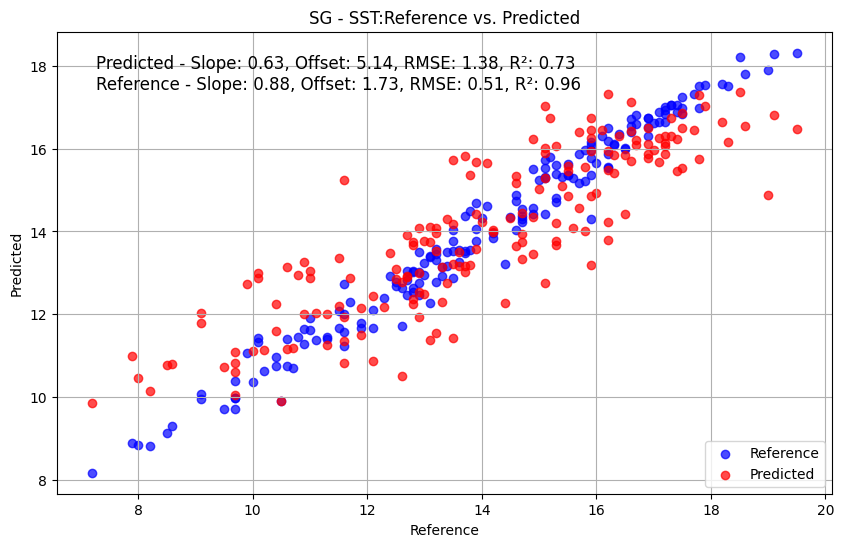

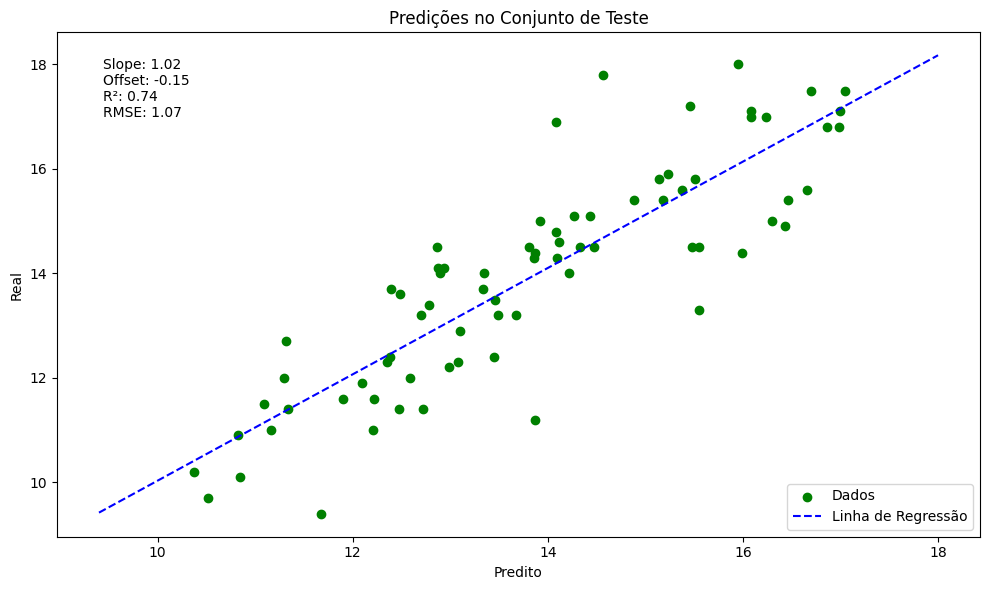

C:\Users\Luyza\AppData\Local\Temp\ipykernel_20116\1584603334.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plot_infos_pre = pd.concat([plot_infos_pre, plot_infos_df], ignore_index=True)


In [20]:
results_sg_sst = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['SST'].values, df_sg_val.iloc[:, 6:], df_sg_val['SST'].values, 'SG', 'SST')
infos_sg = add_plot_infos(infos_sg, results_sg_sst, 'SST')

=== Training Metrics ===
R²: 0.9272
Correlation coefficient: 0.9765
RMSE: 0.1583
MAE: 0.0923
Relative absolute error: 20.4033
Root relative squared error: 26.9844
Slope: 1.1993
Offset: -0.2272
=== Cross-Validation Metrics ===
R²: 0.4814
Correlation coefficient: 0.6959
RMSE: 0.4225
MAE: 0.2507
Relative absolute error: 55.4023
Root relative squared error: 72.0170
Slope: 1.0708
Offset: -0.0976
=== Validation Metrics ===
R²: 0.6558
Correlation coefficient: 0.8237
RMSE: 0.2563
MAE: 0.1965
Relative absolute error: 55.5588
Root relative squared error: 58.6723
Slope: 1.0304
Offset: -0.1003


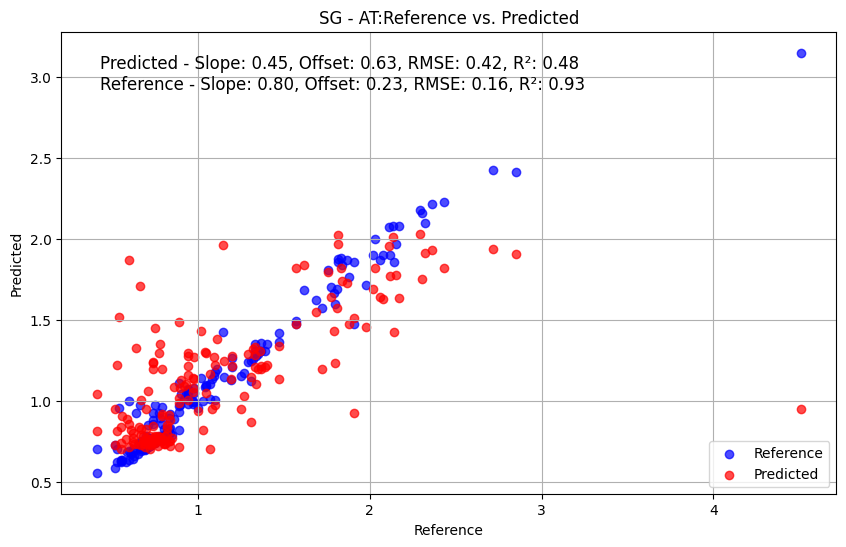

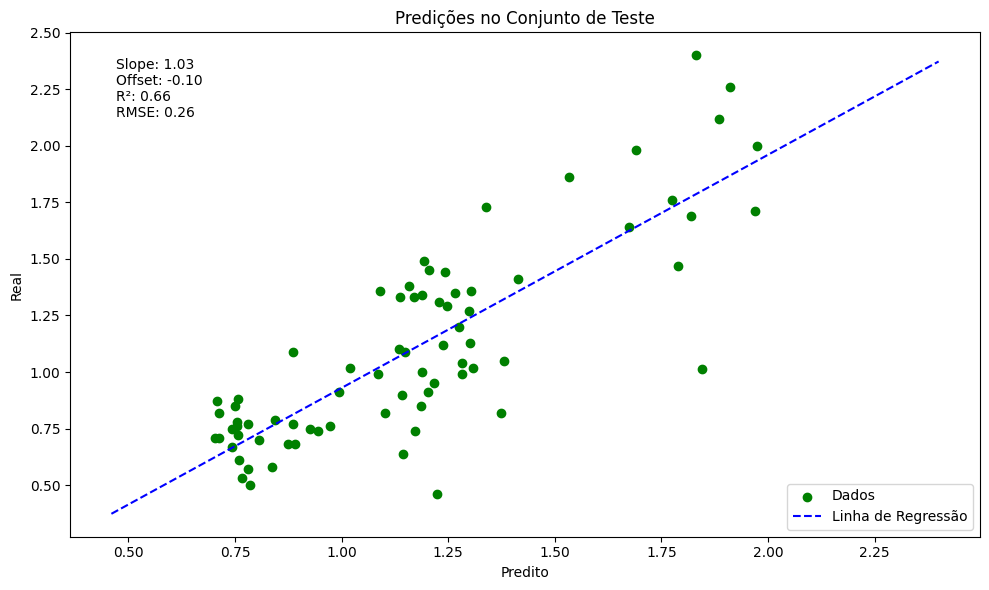

In [21]:
results_sg_at = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['AT'].values, df_sg_val.iloc[:, 6:], df_sg_val['AT'].values, 'SG', 'AT')
infos_sg = add_plot_infos(infos_sg, results_sg_at, 'AT')

=== Training Metrics ===
R²: 0.9116
Correlation coefficient: 0.9777
RMSE: 0.0919
MAE: 0.0564
Relative absolute error: 23.4767
Root relative squared error: 29.7349
Slope: 1.2742
Offset: -0.8954
=== Cross-Validation Metrics ===
R²: 0.3720
Correlation coefficient: 0.6122
RMSE: 0.2448
MAE: 0.1493
Relative absolute error: 62.1613
Root relative squared error: 79.2488
Slope: 1.0954
Offset: -0.3138
=== Validation Metrics ===
R²: 0.5914
Correlation coefficient: 0.7696
RMSE: 0.1673
MAE: 0.1244
Relative absolute error: 53.0838
Root relative squared error: 63.9211
Slope: 0.9799
Offset: 0.0725


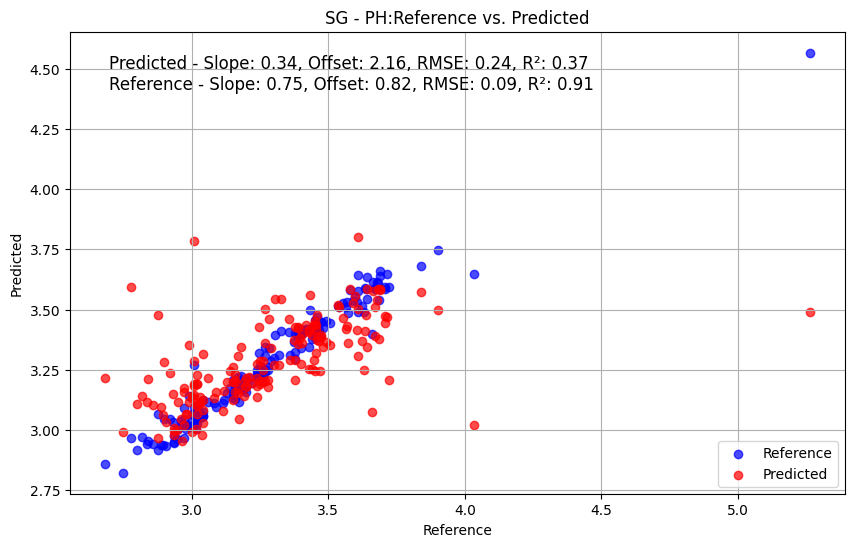

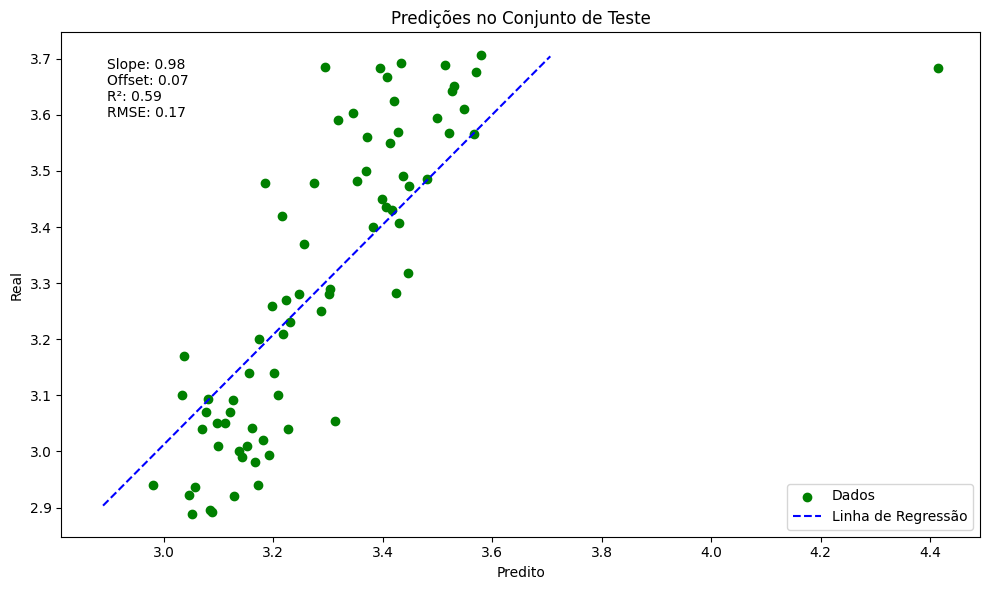

In [22]:
results_sg_ph = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['PH'].values, df_sg_val.iloc[:, 6:], df_sg_val['PH'].values, 'SG', 'PH')
infos_sg = add_plot_infos(infos_sg, results_sg_ph, 'PH')

=== Training Metrics ===
R²: 0.9221
Correlation coefficient: 0.9791
RMSE: 28.6864
MAE: 22.6840
Relative absolute error: 27.2409
Root relative squared error: 27.9127
Slope: 1.2422
Offset: -125.0583
=== Cross-Validation Metrics ===
R²: 0.4176
Correlation coefficient: 0.6492
RMSE: 78.4298
MAE: 62.5332
Relative absolute error: 75.0952
Root relative squared error: 76.3146
Slope: 1.1047
Offset: -54.7610
=== Validation Metrics ===
R²: 0.5301
Correlation coefficient: 0.7363
RMSE: 52.9539
MAE: 42.4037
Relative absolute error: 66.8147
Root relative squared error: 68.5475
Slope: 1.0464
Offset: -31.7348


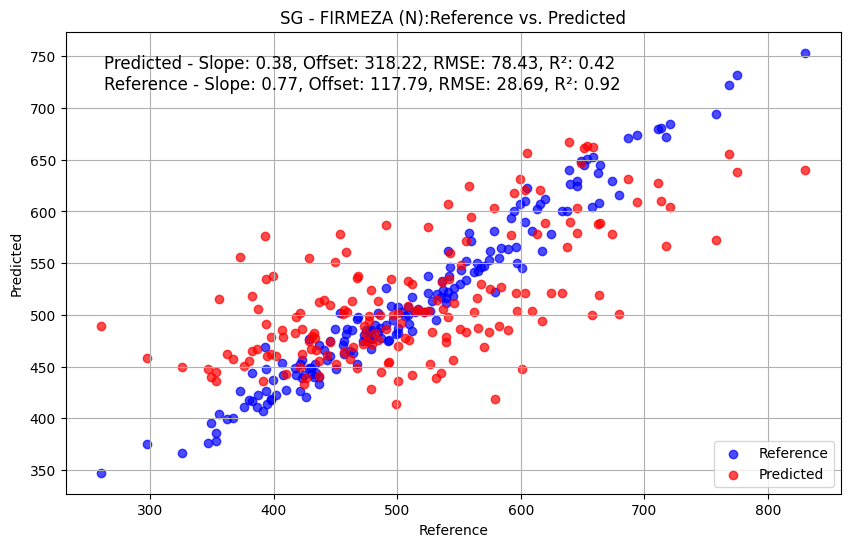

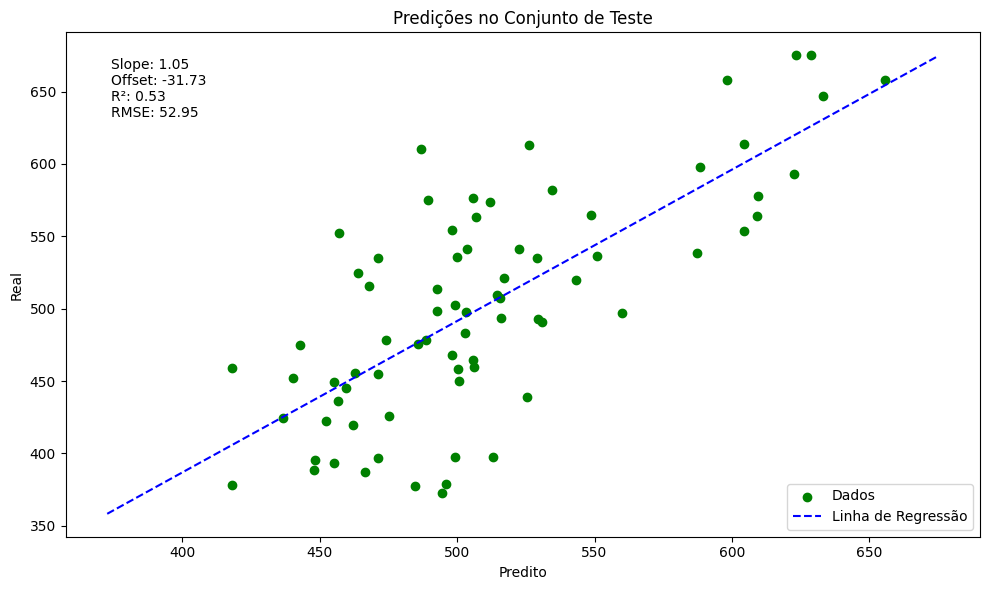

In [23]:
results_sg_firmeza = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['FIRMEZA (N)'].values, df_sg_val.iloc[:, 6:], df_sg_val['FIRMEZA (N)'].values, 'SG', 'FIRMEZA (N)')
infos_sg = add_plot_infos(infos_sg, results_sg_firmeza, 'FIRMEZA (N)')

=== Training Metrics ===
R²: 0.9360
Correlation coefficient: 0.9751
RMSE: 0.8138
MAE: 0.4407
Relative absolute error: 17.8479
Root relative squared error: 25.3006
Slope: 1.1426
Offset: -2.1813
=== Cross-Validation Metrics ===
R²: 0.6324
Correlation coefficient: 0.8011
RMSE: 1.9502
MAE: 1.1409
Relative absolute error: 46.2047
Root relative squared error: 60.6329
Slope: 1.1383
Offset: -2.1304
=== Validation Metrics ===
R²: 0.7998
Correlation coefficient: 0.8962
RMSE: 0.9695
MAE: 0.7502
Relative absolute error: 42.2808
Root relative squared error: 44.7392
Slope: 0.9396
Offset: 0.9171


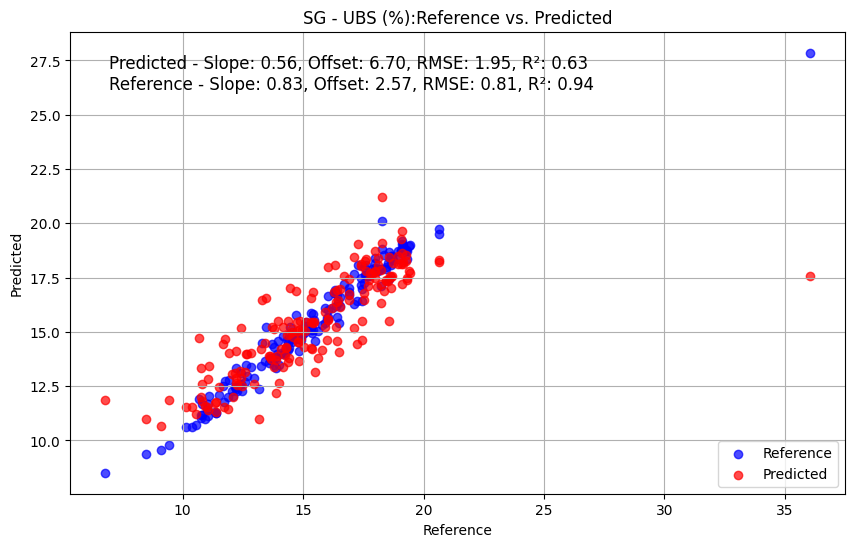

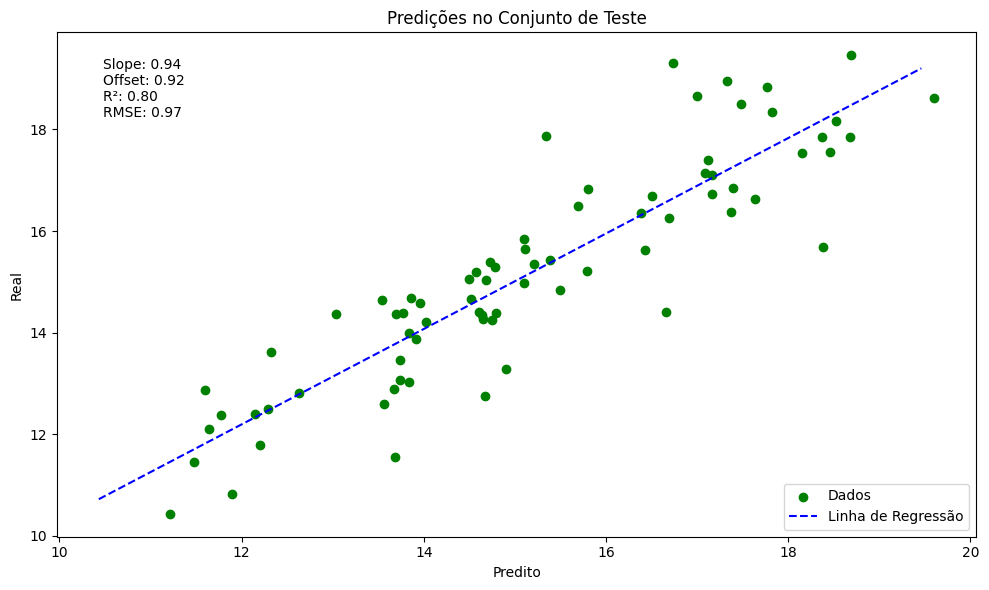

In [24]:
results_sg_ubs = RFR(df_sg_cal.iloc[:, 6:], df_sg_cal['UBS (%)'].values, df_sg_val.iloc[:, 6:], df_sg_val['UBS (%)'].values, 'SG', 'UBS (%)')
infos_sg = add_plot_infos(infos_sg, results_sg_ubs, 'UBS (%)')

In [25]:
infos_sg.to_excel('plot_infos_RFR_sg.xlsx', index=False)
infos_sg

,Attribute,Y,R²,Correlation coefficient,RMSE,MAE,Relative absolute error,Root relative squared error,Slope,Offset
0,SST,Training,0.963845,0.986705,0.505247,0.407400,18.422372,19.014459,1.111111,-1.549079
1,SST,Cross-Validation,0.730886,0.865281,1.378439,1.113829,50.366628,51.876165,1.182399,-2.563043
2,SST,Validation,0.742188,0.863001,1.067197,0.824550,48.028308,50.775162,1.017849,-0.145407
3,AT,Training,0.927184,0.976498,0.158295,0.092335,20.403338,26.984377,1.199319,-0.227229
4,AT,Cross-Validation,0.481355,0.695925,0.422465,0.250723,55.402315,72.017028,1.070827,-0.097639
5,AT,Validation,0.655756,0.823669,0.256334,0.196530,55.558840,58.672308,1.030355,-0.100303
6,PH,Training,0.911583,0.977730,0.091870,0.056404,23.476691,29.734930,1.274159,-0.895436
7,PH,Cross-Validation,0.371963,0.612218,0.244849,0.149346,62.161270,79.248758,1.095417,-0.313777
8,PH,Validation,0.591409,0.769585,0.167302,0.124428,53.083760,63.921147,0.979927,0.072512
9,FIRMEZA (N),Training,0.922088,0.979061,28.686377,22.683988,27.240863,27.912734,1.242155,-125.058331


# Teste

In [4]:
X_test, y_test = df_msc_val.iloc[:,6:], df_msc_val['SST'].values
X_train, y_train = df_msc_cal.iloc[:,6:], df_msc_cal['SST'].values

In [8]:
# Definir o pipeline
pipeline = make_pipeline(
    StandardScaler(),  # Normalização dos dados
    RandomForestRegressor(
        random_state=1  # Semente aleatória para reprodutibilidade
    )
)

# Definir os parâmetros para o GridSearch
param_grid = {
    'randomforestregressor__n_estimators': [50, 80],  # Número de árvores
    'randomforestregressor__max_features': ['sqrt', 'log2'],  # Número de características consideradas para cada divisão
    'randomforestregressor__max_depth': [20, 30, 40],  # Profundidade máxima da árvore
    'randomforestregressor__min_samples_split': [2, 5],  # Número mínimo de amostras necessárias para dividir um nó
    'randomforestregressor__min_samples_leaf': [1, 2],  # Número mínimo de amostras necessárias em um nó folha
    'randomforestregressor__bootstrap': [True, False],  # Amostragem bootstrap
}

# Definir o GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Usando MAE como métrica de avaliação
    cv=175,  # Validação cruzada com 5 folds
    n_jobs=-1,  # Utiliza todos os processadores disponíveis
    verbose=3  # Mostra detalhes do processo
)

# Treinar o GridSearchCV
grid_search.fit(X_train, y_train)

# Resultados do GridSearch
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Fazer previsões no conjunto de teste usando o melhor modelo encontrado
y_pred = grid_search.predict(X_test)

# Calcular e exibir as métricas de desempenho
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nResultados no conjunto de teste:")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")


Fitting 175 folds for each of 96 candidates, totalling 16800 fits


Melhores parâmetros encontrados:
{'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 'log2', 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 80}

Resultados no conjunto de teste:
MAE (Mean Absolute Error): 0.9844
RMSE (Root Mean Squared Error): 1.1926
R² (Coeficiente de Determinação): 0.6788


In [3]:
def testrfr(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "Correlation coefficient": correlation_coefficient,
            "Mean absolute error": mae,
            "Root mean squared error": rmse,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Total Number of Instances": len(y_true)
        }

    def display_metrics(title, metrics):
        print(f"\n=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val

    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        RandomForestRegressor(
            n_estimators=50,  # Número de árvores
            max_features='sqrt', # Usar raiz quadrada do número de características
            max_depth=20,    # Profundidade das árvores
            min_samples_split=2,  # Número mínimo de amostras necessárias para dividir um nó
            min_samples_leaf=1,   # Número mínimo de amostras necessárias em um nó folha
            bootstrap=True,    # Usar amostragem bootstrap
            oob_score=False,   # Não usar amostragem fora da bolsa
            random_state=1     # Semente aleatória
        )
    )

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results = []

    for metric, value in training_metrics.items():
        results.append({'Métrica': f'Training {metric}', 'Valor': value})
    
    for metric, value in cv_metrics.items():
        results.append({'Métrica': f'CV {metric}', 'Valor': value})
    
    for metric, value in validation_metrics.items():
        results.append({'Métrica': f'Validation {metric}', 'Valor': value})

    # Converter os resultados para um DataFrame
    results_df = pd.DataFrame(results)
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title("Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Reference - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nPredicted - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df
